# Modelling

Parts of Preprocessing:
* Data Load
* Encoding
* Train-Test Split
* Neural Network Initialization
* Activation FUnction
* Training
* Model Evaluation
* Visualization

In [11]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Data Load

In [12]:
def load_data(data_dir, img_size=(32, 32)):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, image_file)
                img = Image.open(img_path).convert("L").resize(img_size)
                
                # Original image
                img_array = np.array(img).flatten() / 255.0
                images.append(img_array)
                labels.append(label)
                
                # Augmentation: flipped image
                img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
                img_flipped_array = np.array(img_flipped).flatten() / 255.0
                images.append(img_flipped_array)
                labels.append(label)
    return np.array(images), np.array(labels)

data_dir = "./../../data/processed/" 
img_size = (180, 180)
X, y = load_data(data_dir, img_size=img_size)

### Encoding

In [13]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = np.eye(len(np.unique(y_encoded)))[y_encoded]

### Train-Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

### Neural Network Initialization

In [ ]:
input_size = X_train.shape[1]
hidden_size = 64
output_size = y_onehot.shape[1]
learning_rate = 0.01
epochs = 2000
lambda_reg = 0.001 

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

### Activation Function

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

### Training

In [17]:
for epoch in range(epochs):
    z1 = np.dot(X_train, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    loss = -np.mean(np.sum(y_train * np.log(a2 + 1e-8), axis=1)) + (lambda_reg / 2) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    dz2 = a2 - y_train
    dW2 = (np.dot(a1.T, dz2) / X_train.shape[0]) + (lambda_reg * W2)
    db2 = np.sum(dz2, axis=0, keepdims=True) / X_train.shape[0]
    
    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * sigmoid_derivative(a1)
    dW1 = (np.dot(X_train.T, dz1) / X_train.shape[0]) + (lambda_reg * W1)
    db1 = np.sum(dz1, axis=0, keepdims=True) / X_train.shape[0]
    
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 2.1929
Epoch 500, Loss: 1.6808
Epoch 1000, Loss: 1.5413
Epoch 1500, Loss: 1.4749


### Model Evaluation

In [18]:
z1_test = np.dot(X_test, W1) + b1
a1_test = sigmoid(z1_test)
z2_test = np.dot(a1_test, W2) + b2
a2_test = softmax(z2_test)

predictions = np.argmax(a2_test, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = np.mean(predictions == y_true)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.5599


### Visualization

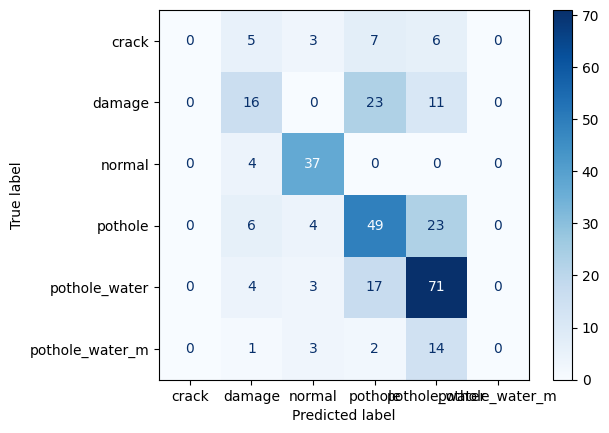

In [19]:
cm = confusion_matrix(y_true, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.show()

['crack' 'damage' 'normal' 'pothole' 'pothole_water']


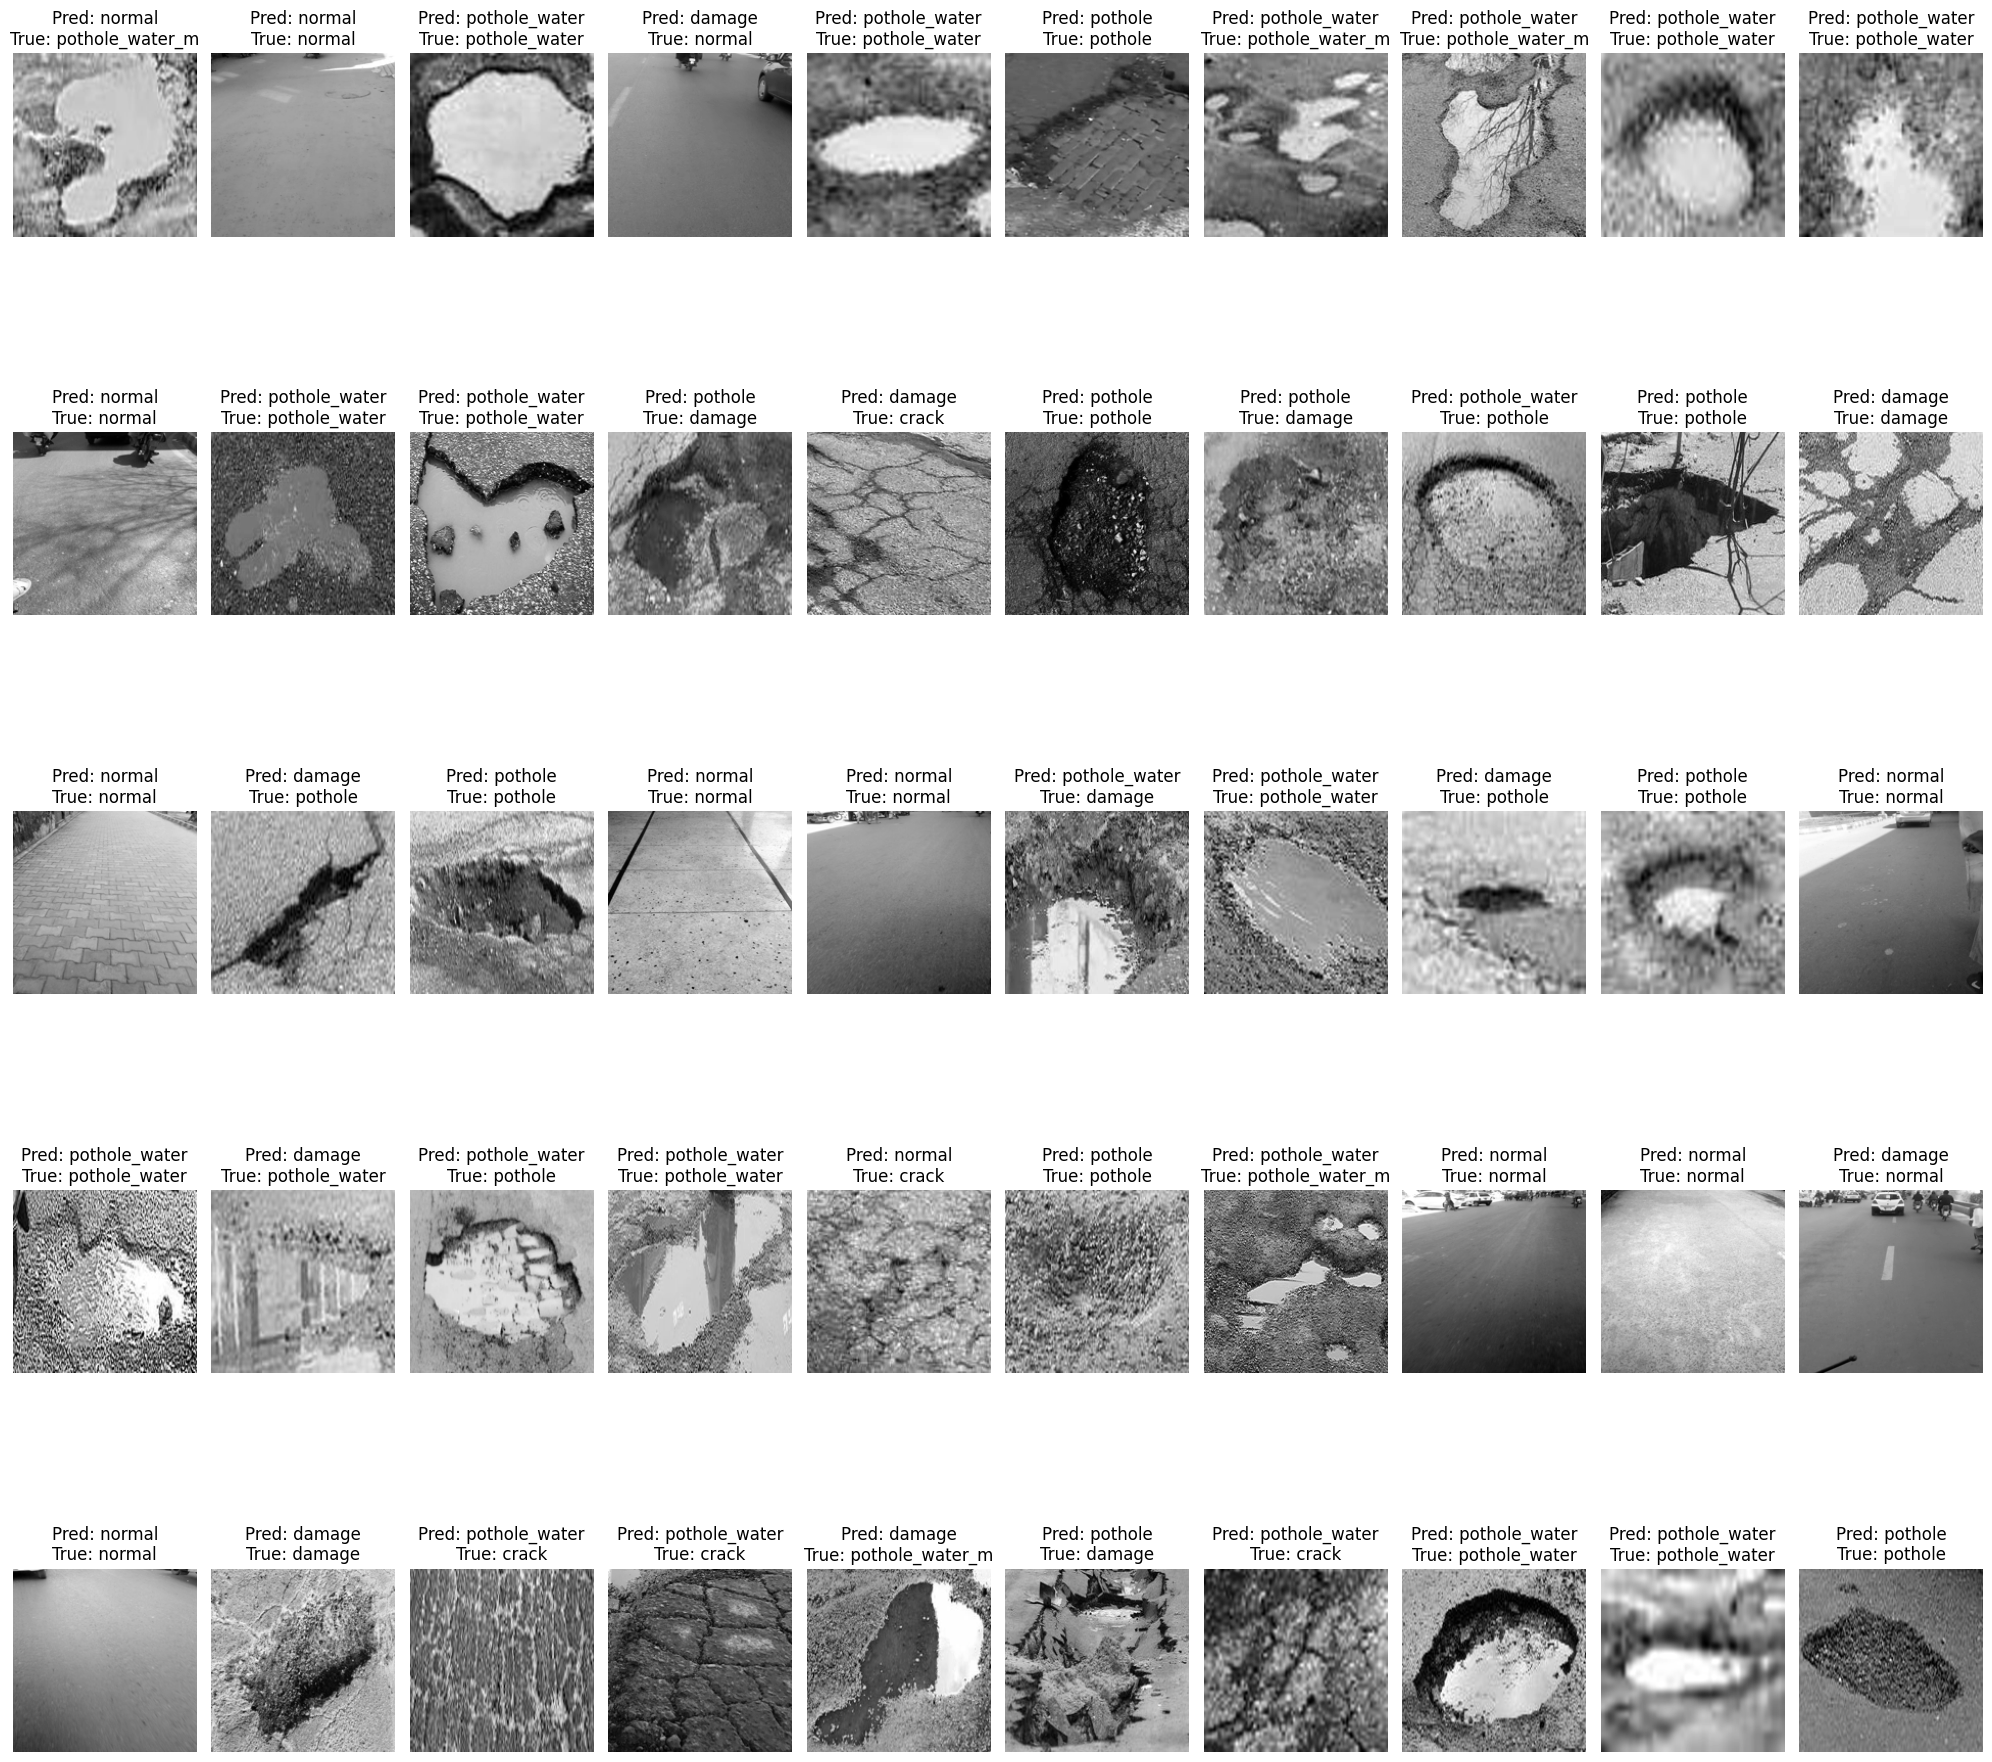

In [20]:
print(label_encoder.inverse_transform([0, 1, 2, 3, 4]))
fig, axes = plt.subplots(5, 10, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(img_size), cmap="gray")
    ax.axis("off")
    pred_label = label_encoder.inverse_transform([predictions[i]])[0]
    true_label = label_encoder.inverse_transform([y_true[i]])[0]
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
plt.tight_layout()
plt.show()